<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Kaggle---Don't-Get-Kicked" data-toc-modified-id="Kaggle---Don't-Get-Kicked-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Kaggle - Don't Get Kicked</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Scoring" data-toc-modified-id="Scoring-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Scoring</a></span></li></ul></li><li><span><a href="#Future-Improvements" data-toc-modified-id="Future-Improvements-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Future Improvements</a></span></li></ul></div>

In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
themes = get_themes()
set_nb_theme(themes[3])

In [2]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
from xgboost import XGBClassifier
from sortedcontainers import SortedSet
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from mlutils.transformers import Preprocessor
from utils import clean, build_xgb, write_output

%watermark -a 'Ethen' -d -t -v -p numpy,scipy,pandas,joblib,xgboost,sklearn,matplotlib,sortedcontainers

Ethen 2017-12-21 15:28:52 

CPython 3.5.2
IPython 6.2.1

numpy 1.13.3
scipy 1.0.0
pandas 0.20.3
joblib 0.11
xgboost 0.6
sklearn 0.19.1
matplotlib 2.1.0
sortedcontainers 1.5.7


# Kaggle - Don't Get Kicked

Problem description is available at https://www.kaggle.com/c/DontGetKicked

Please download the training and testing dataset provided at the link above and store it under the `../data` directory (i.e. there should be a data directory one level above this notebook).

The `utils.py` contains utility function to prevent cluttering the notebook.

## Preprocessing

In [3]:
# original raw data
data_dir = os.path.join('..', 'data')
path_train = os.path.join(data_dir, 'training.csv')
data = pd.read_csv(path_train)
data.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


The next section specifies the categorical, numerical, datetime columns, columns that are dropped and the rationale behind them.

Columns that are dropped:

For categorical variables, use `dataframe[colname].value_counts()` to check for the number of distinct categories, we'll choose to drop columns with too many distinct categories (number of categories is listed in the parenthesis)

- Make (33), have potential for binning
- Model (1063)
- Trim (134)
- SubModel (863), have potential for binning the first two keywords, e.g. 4D SEDAN LS, 4D SEDAN SE would get merged into 4D SEDAN
- Color (16)
- VNST (37), state where the car was purchased, so could potentially bin into regions
- BYRNO (17), unique number assigned to the buyer that purchased the vehicle
- RefId, id for vehicle (each observation) is dropped
- BYRNO (74), id for buyer that bought the vehicle is dropped
- VNZIP1 (153), zipcode where the car was purchased, most likely duplicated effect with column VNST

Columns that are drop due to too many null values, (percentage of null is listed in the parenthesis):

- PRIMEUNIT (0.95)
- AUCGUART (0.95)

Drop due to being a redundant column:

- VehYear measures identical information as VehAge
- WheelTypeID measures identical information as WheelType

In [4]:
# note that the drop_cols variable indicating which columns are dropped is not
# actually used, this is used in the notebook for sanity checking purpose, i.e.
# ensuring the column number adds up to the original column
drop_cols = [
    'Make', 'Model', 'Trim', 'SubModel', 'Color',
    'WheelTypeID', 'VNST', 'BYRNO', 'VNZIP1',
    'PRIMEUNIT', 'AUCGUART', 'VehYear']
cat_cols = [
    'Auction', 'Transmission', 'WheelType', 'Nationality',
    'Size', 'TopThreeAmericanName', 'IsOnlineSale']
num_cols = [
    'VehicleAge', 'VehOdo', 'VehBCost', 'WarrantyCost',
    'MMRCurrentAuctionAveragePrice', 'MMRAcquisitionAuctionAveragePrice',
    'MMRCurrentAuctionCleanPrice', 'MMRAcquisitionAuctionCleanPrice',
    'MMRCurrentRetailAveragePrice', 'MMRAcquisitionRetailAveragePrice',
    'MMRCurrentRetailCleanPrice', 'MMRAcquisitonRetailCleanPrice']
date_cols = ['PurchDate']
label_col = 'IsBadBuy'
ids_col = 'RefId'

# current time for computing recency feature
now = '2011-01-01 00:00:00'

The next code block executes some preprocessing steps that are specific to this problem.

In [5]:
data = clean(path_train, now, cat_cols, num_cols, date_cols, ids_col, label_col)
print('dimension:', data.shape)
data.head()

dimension: (68656, 18)


,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Transmission,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,IsOnlineSale,WarrantyCost,RatioVehBCost,DiffAuctionAveragePrice,DiffAuctionCleanPrice,DiffRetailAveragePrice,DiffRetailCleanPrice
0,1,0,390,ADESA,3,AUTO,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,0,7.014814,0.870632,-0.086327,-0.129922,-0.003352,-0.087574
1,2,0,390,ADESA,5,AUTO,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,0,6.959399,1.108842,0.087832,0.100084,0.043774,0.017420
2,3,0,390,ADESA,4,AUTO,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,0,7.236339,1.530294,0.260150,0.167437,0.029238,0.028970
3,4,0,390,ADESA,5,AUTO,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,0,6.445720,2.165874,-0.025885,-0.010841,-0.060756,-0.030228
4,5,0,390,ADESA,4,MANUAL,Covers,69367,AMERICAN,COMPACT,FORD,0,6.927558,1.022234,-0.170202,-0.132568,-0.127412,-0.091421


In [6]:
# extract target variable, perform
# a quick check of the target variable's skewness
ids = data[ids_col].values
label = data[label_col].values
data = data.drop([ids_col, label_col], axis = 1)
print('labels distribution:', np.bincount(label) / label.size)

labels distribution: [ 0.90365008  0.09634992]


In [7]:
# train/validation stratified split
val_size = 0.1
test_size = 0.1
split_random_state = 1234
df_train, df_test, y_train, y_test, ids_train, ids_test = train_test_split(
    data, label, ids, test_size = test_size,
    random_state = split_random_state, stratify = label)

df_train, df_val, y_train, y_val, ids_train, ids_val = train_test_split(
    df_train, y_train, ids_train, test_size = val_size,
    random_state = split_random_state, stratify = y_train)

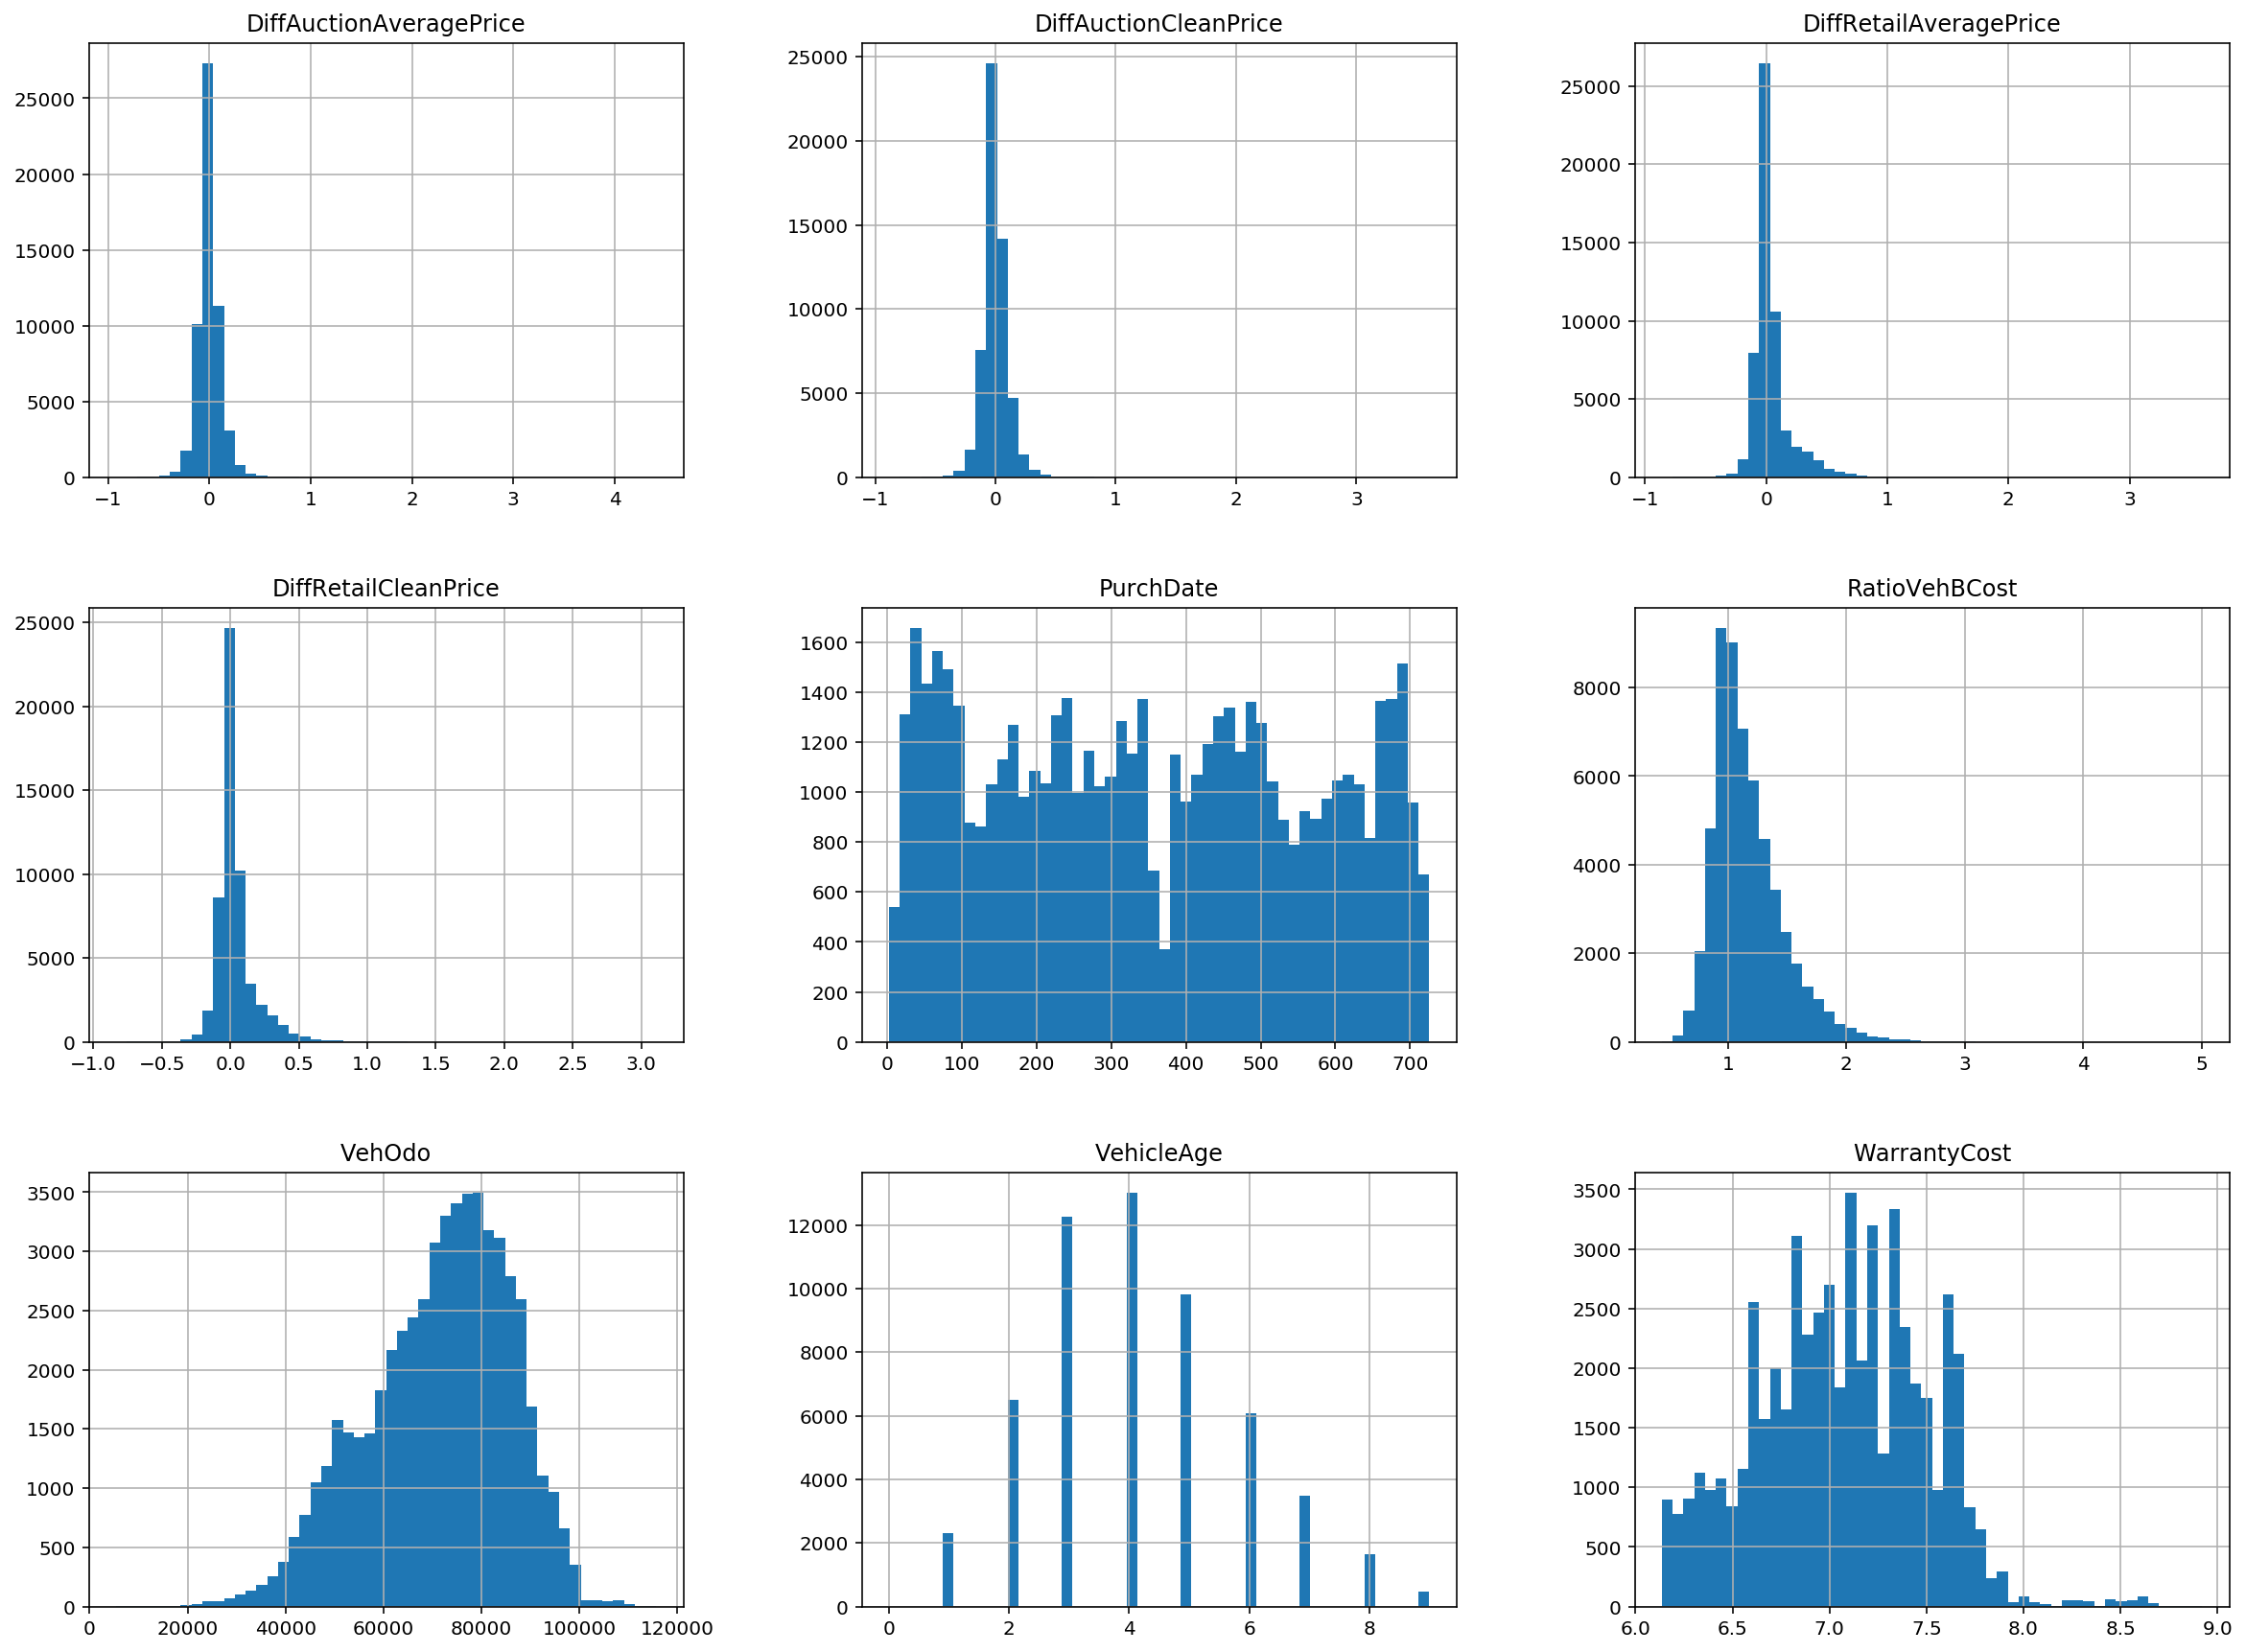

In [8]:
# due the fact that in the cleaning step, some numeric columns
# got transformed, thus we obtain the new numeric columns after
# the cleaning step;
# use sorted set to ensure the consistency of the column order
num_cols_cleaned = list(SortedSet(df_train.columns) - SortedSet(cat_cols))

# final sanity check to ensure numeric columns are
# all normally distributed-ish
df_train[num_cols_cleaned].hist(bins = 50, figsize = (20, 15))
plt.show()

Converts the DataFrame format data to numpy array format.

In [9]:
# ideally this preprocessing step should be constructed
# into a pipeline along with the model, but this is infeasible
# as of now
# https://github.com/dmlc/xgboost/issues/2039
preprocess = Preprocessor(num_cols_cleaned, cat_cols)
X_train = preprocess.fit_transform(df_train)
X_val = preprocess.transform(df_val)
X_test = preprocess.transform(df_test)

print('colnames', preprocess.colnames_)
X_train

colnames ['DiffAuctionAveragePrice' 'DiffRetailCleanPrice' 'PurchDate'
 'RatioVehBCost' 'VehOdo' 'VehicleAge' 'WarrantyCost' 'Auction_MANHEIM'
 'Auction_OTHER' 'Transmission_MANUAL' 'WheelType_Covers'
 'WheelType_Special' 'Nationality_OTHER' 'Nationality_OTHER ASIAN'
 'Nationality_TOP LINE ASIAN' 'Size_CROSSOVER' 'Size_LARGE'
 'Size_LARGE SUV' 'Size_LARGE TRUCK' 'Size_MEDIUM' 'Size_MEDIUM SUV'
 'Size_SMALL SUV' 'Size_SMALL TRUCK' 'Size_SPECIALTY' 'Size_SPORTS'
 'Size_VAN' 'TopThreeAmericanName_FORD' 'TopThreeAmericanName_GM'
 'TopThreeAmericanName_OTHER' 'IsOnlineSale_1']


array([[ 0.19477517, -0.30846916,  0.12175413, ...,  1.        ,
         0.        ,  0.        ],
       [-0.02334776, -0.24487976,  1.1788292 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.48724763, -0.51673078,  1.42532204, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.15637759, -0.18083699,  0.71902525, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05919464, -0.40496127, -0.53239994, ...,  1.        ,
         0.        ,  0.        ],
       [-1.42894175, -0.70013122, -0.57506216, ...,  0.        ,
         0.        ,  0.        ]])

## Modeling

Xgboost (Extreme Gradient Boosting) is chosen for its performance. We also set up a validation set to perform early stopping, which prevents overfitting issues.

In [10]:
cv = 10
n_iter = 3
model_random_state = 4321
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_tuned = build_xgb(n_iter, cv, model_random_state, eval_set)
xgb_tuned.fit(X_train, y_train)
pd.DataFrame(xgb_tuned.cv_results_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   59.3s finished


,mean_fit_time,mean_score_time,mean_test_score,param_colsample_bytree,param_max_depth,param_subsample,params,rank_test_score,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,std_fit_time,std_score_time,std_test_score
0,11.900397,0.075005,0.686643,0.814161,11,0.948466,"{'max_depth': 11, 'subsample': 0.948466023457,...",3,0.685646,0.695112,...,0.708052,0.686293,0.675813,0.686599,0.681322,0.663228,0.697851,4.425606,0.040494,0.011621
1,15.706179,0.050544,0.697675,0.836486,4,0.838619,"{'max_depth': 4, 'subsample': 0.838618862328, ...",2,0.695861,0.691406,...,0.705653,0.703651,0.680469,0.712606,0.687224,0.684035,0.714907,4.482552,0.024669,0.011242
2,16.538330,0.034556,0.699232,0.995782,5,0.951554,"{'max_depth': 5, 'subsample': 0.951553573648, ...",1,0.685623,0.696350,...,0.714285,0.718085,0.676049,0.707545,0.686829,0.690593,0.717867,3.851517,0.020393,0.013992


In [11]:
# model checkpoint for future scoring
model_dir = os.path.join('..', 'model')
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

checkpoint_preprocess = os.path.join(model_dir, 'preprocess.pkl')
checkpoint_xgb = os.path.join(model_dir, 'xgb.pkl')

In [12]:
dump(preprocess, checkpoint_preprocess)
dump(xgb_tuned, checkpoint_xgb)

['../model/xgb.pkl']

In [13]:
# monitor the train, validation and test AUC score
y_pred = []
xgb_best = xgb_tuned.best_estimator_
zipped = zip(
    ('train', 'validation', 'test'),
    (X_train, X_val, X_test),
    (y_train, y_val, y_test))
for name, X, y in zipped:
    xgb_pred = xgb_best.predict_proba(
        X, ntree_limit = xgb_best.best_ntree_limit)[:, 1]
    score = round(roc_auc_score(y, xgb_pred), 2)
    print('{} AUC: {}'.format(name, score))
    y_pred.append(xgb_pred)

train AUC: 0.76
validation AUC: 0.69
test AUC: 0.71


In [14]:
# output the prediction
output_dir = os.path.join('..', 'output')
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

ids = np.hstack((ids_train, ids_val, ids_test))
y_pred = np.hstack(y_pred)

# this prediction table can be written to a .csv or upload back to database
output = pd.DataFrame({
    ids_col: ids,
    label_col: y_pred
}, columns = [ids_col, label_col])
output.head()

,RefId,IsBadBuy
0,35778,0.096131
1,49957,0.034586
2,56827,0.052238
3,22481,0.157512
4,3527,0.065120


In [15]:
# output to .csv file
output_path = os.path.join(output_dir, 'prediction.csv')
write_output(ids, ids_col, y_pred, label_col, output_path)

## Scoring

Scoring a future dataset, here it's scoring the test set provided from Kaggle.

In [16]:
path_future = os.path.join(data_dir, 'test.csv')
data = clean(path_future, now, cat_cols, num_cols, date_cols, ids_col)
ids = data[ids_col].values
data = data.drop(ids_col, axis = 1)

preprocess = load(checkpoint_preprocess)
xgb_tuned = load(checkpoint_xgb)
X = preprocess.transform(data)
xgb_best = xgb_tuned.best_estimator_
xgb_pred = xgb_best.predict_proba(
    X, ntree_limit = xgb_best.best_ntree_limit)[:, 1]

xgb_pred

array([ 0.07718407,  0.07765604,  0.06533021, ...,  0.12580971,
        0.1249803 ,  0.16875109], dtype=float32)

In [17]:
output_path = os.path.join(output_dir, 'prediction_future.csv')
write_output(ids, ids_col, xgb_pred, label_col, output_path)

After understanding the overall workflow, the you can simply use the `main.py` script and follow the steps below to replicate the workflow:

```bash
# assuming you're at the project's root directory

# train the model on the training set and store it
python src/main.py --train --inputfile training.csv --outputfile prediction.csv

# predict on future dataset and output the prediction
# to a .csv file in a output directory (will be created
# one level above where the script is if it doesn't exist yet)
python src/main.py --inputfile test.csv --outputfile prediction_future.csv
```

As of now, most of the changeable parameters used throughout this notebook are coded as constant at the top of script and not exposed as command line arguments.

# Future Improvements

This script reaches around 0.70 ~ 0.72 AUC on the test set. Some potential ways of improving this score includes:

- Leverage more features, e.g. some categorical columns can be included using binning (use intuition or leverage domain experts) or embedding methods and the columns with missing values can be included by converting it to a binary label of whether the column is missing or not as the missing values could potentially be a signal.
- Explicitly add interaction terms by checking the top most important features using model's feature importance or LIME
- Longer iterations for hyperparmeter search or smarter hyperparameter search methods.
- Oversampling, undersampling or a mix of both could be utilized since the dataset is a bit unbalanced. An alternative way to resolve the unbalanced issue is to supply sample weights to each observation, where the observation that represents the minority class will get assigned a higher weight.
- Try other algorithms to obtain performance boost: e.g. deeper learning or stacking.